In [1]:
import os
from pathlib import Path
datapath = '../../../timur/rjd/data'
# ROOT = Path(os.getenv('DATAPATH'))
ROOT = Path(datapath)
# test_image_path = ROOT / 'test'
test_image_path = ROOT / 'test'

In [2]:
import numpy as np
from skimage import io
from torch.utils.data import Dataset, DataLoader

/home/michael/rjd/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class RJDDataset(Dataset):
    def __init__( self, imgs, masks = None, aug = None):
        self.imgs = imgs
        self.masks = masks
        self.aug = aug

    def __len__(self) -> int:
        return len(self.imgs)

    def __getitem__(self, idx: int) -> dict:
        imgpath = self.imgs[idx]
        img = io.imread(imgpath)

        if self.aug is not None:
            auged = self.aug(image=img)
            img = auged['image']

        img = np.moveaxis(img, -1, 0)

        return img

In [4]:
TEST_IMAGES = sorted(test_image_path.glob("*.png"))
TEST_IMAGES

[PosixPath('../../../timur/rjd/data/test/img_0.00045504180876976275.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.0017079007890338227.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.0030897967783596325.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.0036160704081735773.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.004268189807459355.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.006732749469567034.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.006890116269427482.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.006912073265388563.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.007661808580294749.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.008908158614314043.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.00916087594409798.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.009626271122910257.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.011436409441076267.png'),
 PosixPath('../../../timur/rjd/data/test/img_0.

## Transformer inference

In [5]:
# !pip install transformers

In [6]:
from torch import nn
from transformers import SegformerForSemanticSegmentation

class SegFormer4model(nn.Module):
        def __init__(self):
            super(SegFormer4model, self).__init__()
            
            self.base_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
            self.linear = nn.Linear(150, 4) # output features from bert is 768 and 2 is ur number of labels

            self.scaler = nn.Upsample(scale_factor=4, mode='nearest')

            
        def forward(self, inputs):
            segformer_output = self.base_model(inputs).logits   
            segformer_output = segformer_output.transpose(1, 3).transpose(1, 2)

            outputs = self.linear(segformer_output)
            outputs = outputs.transpose(1, 2).transpose(1, 3)
            outputs = self.scaler(outputs)
            return outputs

model = SegFormer4model()


In [7]:
import torch

state = torch.load('../18-07-22:02-08_model_segformer_extra_augs.pth', map_location=torch.device('cpu'))

model.load_state_dict(state)

<All keys matched successfully>

In [8]:
import albumentations as A

TEST_IMAGES = sorted(test_image_path.glob("*.png"))

# create test dataset
test_dataset = RJDDataset(
    TEST_IMAGES, 
    aug=A.Compose([
        A.Resize( height=512, 
                    width=512, 
                    p=1. ),
    ])
)

num_workers: int = 4
batch_size = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [9]:
model.eval()
model.cuda(0)

SegFormer4model(
  (base_model): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (

In [10]:
from tqdm import tqdm
import cv2

apreds = list()

for imgs_batch in tqdm(infer_loader):
    preds = model(imgs_batch.float().cuda()).data.cpu().numpy()
    apreds.append(preds)
    
apreds = np.vstack(apreds)

100%|██████████| 250/250 [06:05<00:00,  1.46s/it]


In [11]:
for path, mask in tqdm(zip(TEST_IMAGES, apreds)):
    shape = io.imread(path).shape[:-1][::-1]
    mask = np.swapaxes(np.swapaxes(mask, 0, 1), 1, 2)
    rmask = cv2.resize(mask, shape, interpolation=cv2.INTER_CUBIC)
    rmask = rmask.argmax(2)
    rmask[rmask == 1] = 6
    rmask[rmask == 2] = 7
    rmask[rmask == 3] = 10
    io.imsave(f'./submits_transformer/3/{path.name}', rmask.astype(np.uint8), check_contrast=False)
    

1000it [29:27,  1.77s/it]


## UNet inference

In [5]:
from nn_tools.models import UnetSm

In [6]:
model = UnetSm( in_channels=3,
                out_channels=4,
                encoder_name='resnext50_32x4d',
                encoder_weights='ssl',
                decoder_attention_type='scse' )


In [7]:
import torch

state = torch.load('./baseline/03-07-22:17-30_model_unet_baseline.pth', map_location=torch.device('cpu'))

model.load_state_dict(state)


<All keys matched successfully>

In [8]:
model.eval()
model.cuda()

UnetSm(
  (unet): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [9]:
for path in TEST_IMAGES:
    shape = io.imread(path).shape
    print(shape)

(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(1512, 2688, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(2160, 3840, 3)
(1512, 2688, 3)
(1512, 2

KeyboardInterrupt: 

In [10]:
import cv2

from tqdm import tqdm

apreds = list()

for imgs_batch in tqdm(infer_loader):
    preds = model(imgs_batch.float().cuda()).data.cpu().numpy()
    apreds.append(preds)
    
apreds = np.vstack(apreds)

100%|██████████| 32/32 [02:48<00:00,  5.28s/it]


In [ ]:
import cv2

for path, mask in tqdm(zip(TEST_IMAGES, apreds)):
    shape = io.imread(path).shape[:-1][::-1]
    mask = np.swapaxes(np.swapaxes(mask, 0, 1), 1, 2)
    rmask = cv2.resize(mask, shape, interpolation=cv2.INTER_CUBIC)
    rmask = rmask.argmax(2)
    rmask[rmask == 1] = 6
    rmask[rmask == 2] = 7
    rmask[rmask == 3] = 10
    io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
    

0it [00:00, ?it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.00045504180876976275.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
1it [00:00,  2.14it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.0017079007890338227.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
2it [00:00,  2.06it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.0030897967783596325.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
3it [00:01,  2.10it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.0036160704081735773.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
4it [00:02,  1.98it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.0042

37it [00:15,  2.07it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.03719841343542629.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
38it [00:16,  1.73it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.03746236182721052.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
39it [00:16,  2.06it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.03948582759796426.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
40it [00:17,  1.60it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.039710362590859805.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
41it [00:18,  1.87it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.040

74it [00:32,  1.54it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.06516091753391118.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
75it [00:33,  1.72it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.06581657670491503.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
76it [00:33,  1.84it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.06612010208837416.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
77it [00:33,  2.22it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.06627821816004353.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
78it [00:34,  2.50it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.0662

111it [00:48,  2.25it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.09999346860218816.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
112it [00:48,  2.48it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.1038146314941647.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
113it [00:49,  2.69it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.10390883556666919.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
114it [00:49,  2.57it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.10438484049107077.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
115it [00:50,  2.33it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.

148it [01:04,  2.26it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.13110941017832034.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
149it [01:04,  2.22it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.13116199354808356.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
150it [01:05,  2.17it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.13320221704945046.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
151it [01:05,  2.47it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.13326052777778208.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
152it [01:05,  2.65it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0

185it [01:18,  2.49it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.1690471581922206.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
186it [01:18,  2.71it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.16976168613178677.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
187it [01:19,  2.92it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.16991180794859018.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
188it [01:19,  3.18it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.1699876831735868.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
189it [01:19,  2.63it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.1

222it [01:33,  1.87it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.19862794051283994.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
223it [01:34,  2.15it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.2002056785376537.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
224it [01:34,  2.15it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.2010913794511795.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
225it [01:35,  2.06it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.20269248668551065.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
226it [01:35,  2.42it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.2

259it [01:48,  2.82it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.23433948089973555.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
260it [01:48,  3.10it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.23821859111146215.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
261it [01:48,  2.55it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.2414943654360242.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
262it [01:49,  2.26it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.24241851527752356.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
263it [01:49,  2.46it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.

296it [02:02,  2.05it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.27616785163266944.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
297it [02:02,  2.43it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.277061116090067.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
298it [02:02,  2.69it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.2774900401121626.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
299it [02:02,  2.98it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.2776369863804592.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
300it [02:03,  3.24it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.285

333it [02:16,  2.77it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.31963904494771567.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
334it [02:17,  2.53it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.32027580006207323.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
335it [02:17,  2.70it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.3217811142599899.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
336it [02:18,  2.37it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.32265991097763136.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
337it [02:18,  2.58it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.

370it [02:32,  2.55it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.36189065565004763.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
371it [02:32,  2.81it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.36325242379273914.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
372it [02:33,  2.34it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.3668904071823962.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
373it [02:33,  2.74it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.3671669501862943.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
374it [02:33,  2.87it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.3

407it [02:46,  2.07it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.3967616979388888.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
408it [02:46,  2.41it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.39793820614073405.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
409it [02:47,  2.32it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.39886142699750415.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
410it [02:47,  2.19it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.40104218244887657.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
411it [02:48,  2.50it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.

444it [03:01,  2.38it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4374178844219354.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
445it [03:01,  2.62it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4374552223107584.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
446it [03:02,  2.86it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4390133356523429.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
447it [03:02,  2.96it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.43969375295920765.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
448it [03:03,  2.63it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.44

481it [03:16,  2.33it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4792947634405881.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
482it [03:16,  2.19it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4802141079668888.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
483it [03:17,  2.11it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4834464216812291.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
484it [03:17,  2.34it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.4852799410300984.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
485it [03:17,  2.60it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.485

518it [03:32,  2.04it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5149610921619838.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
519it [03:33,  2.03it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5154362427528322.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
520it [03:33,  2.37it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5157631388297299.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
521it [03:33,  2.74it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5184545528589714.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
522it [03:34,  2.52it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.519

555it [03:47,  2.40it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5580163179705945.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
556it [03:47,  2.70it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5592379259442606.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
557it [03:48,  2.41it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5625306689724435.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
558it [03:48,  2.30it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.5625360630219185.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
559it [03:49,  2.12it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.563

592it [03:59,  3.02it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6078786574620273.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
593it [04:00,  2.66it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6083556373076855.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
594it [04:00,  2.39it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6096506432289848.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
595it [04:01,  2.20it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6111740874464914.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
596it [04:01,  2.18it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.612

629it [04:14,  2.50it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6410431153683189.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
630it [04:15,  2.27it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6431871504042173.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
631it [04:15,  2.40it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6435424273030166.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
632it [04:16,  2.29it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6437325107358857.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
633it [04:16,  2.25it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.644

666it [04:29,  2.71it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.677322818767454.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
667it [04:29,  2.41it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.678214752757961.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
668it [04:29,  2.64it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.6782427066039306.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
669it [04:30,  2.51it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.678391689053897.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
670it [04:30,  2.81it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.678878

703it [04:42,  2.45it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7082778426841886.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
704it [04:43,  2.72it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7097667137282139.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
705it [04:43,  2.88it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7100240632857432.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
706it [04:43,  3.11it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7102090987561666.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
707it [04:44,  2.78it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.712

740it [04:57,  2.38it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7381701669604822.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
741it [04:58,  2.16it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.738206613045342.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
742it [04:58,  2.40it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7383057966630799.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
743it [04:59,  2.14it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7391790046945271.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
744it [04:59,  2.34it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7410

777it [05:13,  2.93it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7707706398385821.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
778it [05:13,  2.44it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7711601901865652.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
779it [05:14,  2.24it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.771276337268119.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
780it [05:14,  2.40it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7716220325772223.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
781it [05:15,  2.29it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.7718

814it [05:28,  2.44it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8030691035887241.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
815it [05:28,  2.68it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8032578465774912.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
816it [05:28,  2.45it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8045714601853001.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
817it [05:29,  2.73it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8048752422426186.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
818it [05:29,  2.97it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.806

851it [05:42,  2.16it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8428372870486844.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
852it [05:42,  2.15it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8429502637305889.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
853it [05:42,  2.46it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8446357036291637.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
854it [05:43,  2.42it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8455275165334826.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
855it [05:43,  2.68it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.845

888it [05:56,  2.19it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.887214983786602.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
889it [05:57,  2.07it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8881055928445108.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
890it [05:57,  2.31it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.889172406573969.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
891it [05:58,  2.18it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.8895127639779988.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
892it [05:58,  2.21it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.88984

925it [06:12,  2.56it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.9188415484962651.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
926it [06:12,  2.87it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.9189424406983114.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
927it [06:12,  2.58it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.9205792826573842.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
928it [06:13,  2.48it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.9240453642770377.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
929it [06:13,  2.15it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.924

962it [06:26,  2.84it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.9598232669119426.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
963it [06:26,  3.09it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.960844227703824.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
964it [06:27,  2.61it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.962349491900517.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
965it [06:27,  2.45it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.9632600869650018.png is a low contrast image
  io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
966it [06:28,  2.28it/s]/tmp/ipykernel_1254928/3105337502.py:11: UserWarning: ./submit_resize_test/img_0.96481

(1512, 2688)


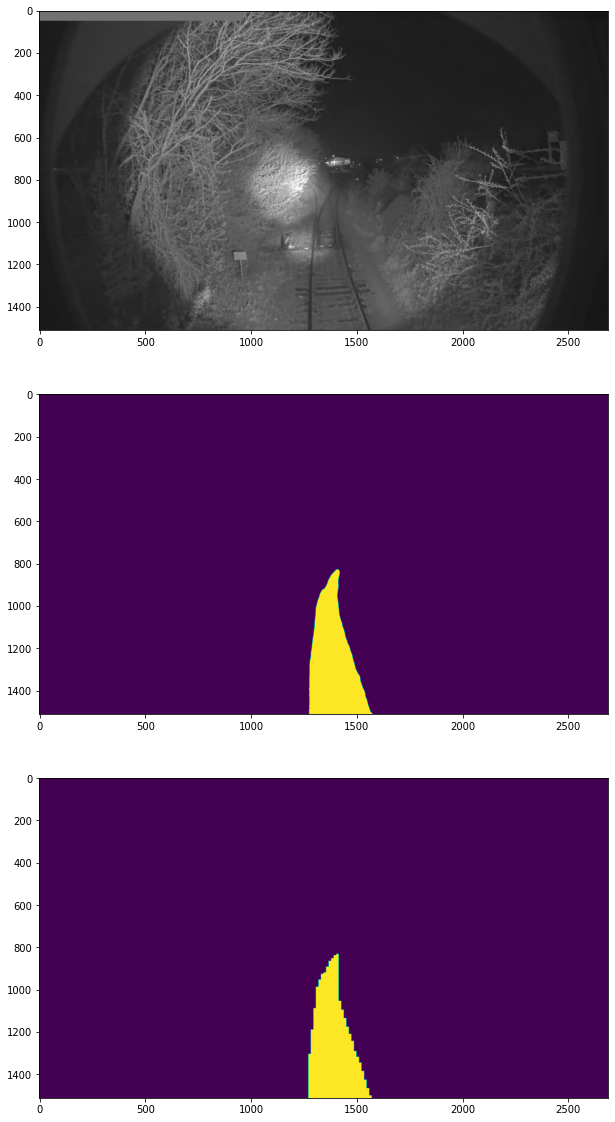

In [27]:
import matplotlib.pyplot as plt
idx = 20

path = TEST_IMAGES[idx]
mask = np.swapaxes(np.swapaxes(apreds[idx], 0, 1), 1, 2)

img = io.imread(path)

shape = img.shape[:-1][::-1]

rmask = cv2.resize(mask, shape, interpolation=cv2.INTER_CUBIC)
rmask = rmask.argmax(2)
print(rmask.shape)

fig, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].imshow(img)
ax[1].imshow(rmask)
ax[2].imshow(old)

In [17]:
apreds[idx].shape

(4, 224, 224)

In [19]:
# old prediction code, argmax before resize
idx = 20

path = TEST_IMAGES[idx]
mask = apreds[idx].argmax(0)
old = cv2.resize(mask, io.imread(path).shape[:-1:][::-1], interpolation=cv2.INTER_NEAREST)


In [20]:
len(TEST_IMAGES)

1000

In [24]:
import glob
len(glob.glob('submit_resize_test/*'))

1001

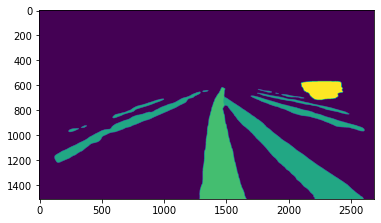

In [14]:
import matplotlib.pyplot as plt
test = io.imread('submit_resize_test/img_0.008908158614314043.png')
plt.imshow(test)

In [15]:
np.unique(test)

array([ 0,  6,  7, 10], dtype=uint8)

In [16]:
import matplotlib.pyplot as plt

In [45]:
np.unique(apreds[9].argmax(0))

array([0, 1, 2, 3])

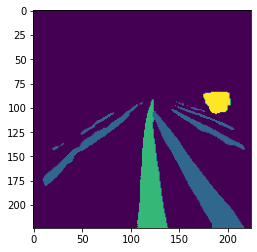

In [28]:
plt.imshow(apreds[9])

## Folds validation

In [1]:
import numpy as np
import torch
from skimage import io
from torch.utils.data import Dataset, DataLoader
import cv2

from tqdm import tqdm


class RJDDataset(Dataset):
    def __init__( self, imgs, masks = None, aug = None):
        self.imgs = imgs
        self.masks = masks
        self.aug = aug

    def __len__(self) -> int:
        return len(self.imgs)

    def __getitem__(self, idx: int) -> dict:
        imgpath = self.imgs[idx]
        img = io.imread(imgpath)

        if self.aug is not None:
            auged = self.aug(image=img)
            img = auged['image']

        img = np.moveaxis(img, -1, 0)

        return img

In [2]:
from nn_tools.metrics.segmentation import jaccard_score 

In [3]:
import pandas as pd
a = pd.read_csv("data/split_1/val_img.csv")
len(a['path'].to_list())

1231

In [6]:
def get_predicts(resolution, model_path, val_img_path):
    RJD_data_split = RJDDataset(imgs=val_img_path,
        aug=A.Compose([
            A.Resize( height=resolution, 
                    width=resolution, 
                    p=1. ),
    ]))
        
    infer_loader = DataLoader(
        RJD_data_split,

        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    model = UnetSm(in_channels=3,
            out_channels=4,
            encoder_name='resnext50_32x4d',
            encoder_weights='ssl',
            decoder_attention_type='scse')


    state = torch.load(model_path, map_location=torch.device('cpu'))

    model.load_state_dict(state)
    model.eval()
    model.cuda(0)


    apreds = list()

    for imgs_batch in tqdm(infer_loader):
        preds = model(imgs_batch.float().cuda(0)).data.cpu().numpy()
        apreds.append(preds)

    apreds = np.vstack(apreds)
    return apreds



In [8]:
import os
from nn_tools.models import UnetSm
import torch
import evaluate

from tqdm import tqdm
import albumentations as A

num_workers: int = 4
batch_size = 4
models = ['06-07-22:07-34_model_unet_baseline.pth',
          '06-07-22:18-58_model_unet_baseline.pth',
          '07-07-22:04-18_model_unet_baseline.pth']
resolutions = [224, 336, 512]


final_log = ""
with torch.no_grad():
    for model_name, resolution in zip(models, resolutions):
        model_path = 'baseline/' + model_name 
        for root, dirs, files in os.walk("data"):
            if "split_1" in root and ".ipynb_checkpoints" not in root:
                split = root.split('/')[1]
                val_img_csv = pd.read_csv(root+'/'+files[1])
                val_mask_csv = pd.read_csv(root+'/'+files[2])
#                 val_img_csv = pd.read_csv(root+'/'+files[0])
#                 val_mask_csv = pd.read_csv(root+'/'+files[3])

                val_img_path = sorted(val_img_csv['path'].to_list())
                val_mask_path = sorted(val_mask_csv['path'].to_list())

                apreds = get_predicts(resolution, model_path, val_img_path)
                scores = []


                for path, mask, true_path in tqdm(zip(val_img_path, apreds, val_mask_path)):
                    shape = io.imread(path).shape[:-1][::-1]
                    true_mask = io.imread(true_path)[:, :, 0]
                    mask = np.swapaxes(np.swapaxes(mask, 0, 1), 1, 2)
                    rmask = cv2.resize(mask, shape, interpolation=cv2.INTER_CUBIC)
                    rmask = rmask.argmax(2)

                    score_0 = jaccard_score(rmask==0, true_mask==0, average='macro')
                    score_6 = jaccard_score(rmask==1, true_mask==6, average='macro')
                    score_7 = jaccard_score(rmask==2, true_mask==7, average='macro')
                    score_10 = jaccard_score(rmask==3, true_mask==10, average='macro')
                    mIoU = np.mean([score_0, score_6, score_7, score_10])
                    scores.append(mIoU)
                    

#                 mean_score = mean_iou.compute(predictions=rmasks, references=true_masks, num_labels=4, ignore_index=255)['mean_iou']
                   
                
                mean_score = np.mean(scores)
                log = f"{resolution}, {split}, mean score: {mean_score}"
                print(log)
                final_log += log + '\n'

with open("infer_log_train.txt", "w") as text_file:
    text_file.write(final_log)
            
#             io.imsave(f'./submit_resize_test/{path.name}', rmask.astype(np.uint8))
            


100%|██████████| 308/308 [00:24<00:00, 12.82it/s]
0it [00:00, ?it/s]


AssertionError: No 1 label in confusion matrix

In [9]:
rmask = rmasks[0]
true_mask = true_masks[0]

In [10]:
rmask.shape

(1512, 2688)

In [16]:
rmask[rmask==3]

(633193,)

In [19]:
true_mask.shape

(1512, 2688)

In [8]:
import evaluate


mean_iou = evaluate.load("mean_iou")

results = mean_iou.compute(predictions=[rmask], references=[true_mask], num_labels=4, ignore_index=255)

/home/rost/.cache/huggingface/modules/evaluate_modules/metric/mean_iou/f4bdd0231e7a8e31b92f26088a8645cdd9f729f15bfbefda6a39b897688f7fe2/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/rost/.cache/huggingface/modules/evaluate_modules/metric/mean_iou/f4bdd0231e7a8e31b92f26088a8645cdd9f729f15bfbefda6a39b897688f7fe2/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [10]:
results['mean_iou']

0.9661690861758327

In [11]:
jaccard_score(rmask, true_mask, average='macro')

(0.6978518189148442,)

In [11]:
val_img_path = pd.read_csv("data/split_1/val_img.csv")['path'].to_list()
val_img_mask = pd.read_csv("data/split_1/val_mask.csv")['path'].to_list()
val_img_path, val_img_mask = sorted(val_img_path), sorted(val_img_mask)
# print(f"DEBUG: img: {val_img_path}, masks: {val_img_mask}")

apreds = get_predicts(val_img_path)

100%|██████████| 39/39 [01:34<00:00,  2.43s/it]


In [14]:
def test():
    for path, mask, true_path in tqdm(zip(val_img_path, apreds, val_img_mask)):
        shape = io.imread(path).shape[:-1][::-1]
        true_mask = io.imread(true_path)
        mask = np.swapaxes(np.swapaxes(mask, 0, 1), 1, 2)
        rmask = cv2.resize(mask, shape, interpolation=cv2.INTER_CUBIC)
        rmask = rmask.argmax(2)
        rmask[rmask == 1] = 6
        rmask[rmask == 2] = 7
        rmask[rmask == 3] = 10
        return rmask, true_mask

rmask, true_mask = test()

0it [00:00, ?it/s]


In [15]:
rmask.shape

(1512, 2688)

In [16]:
true_mask.shape

(1512, 2688, 3)

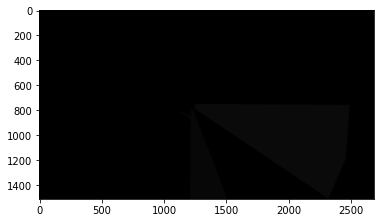

In [18]:
import matplotlib.pyplot as plt
plt.imshow(true_mask)

In [20]:
import cv2 


    

1it [00:00,  3.13it/s]

(0.9401847387685817,)



2it [00:00,  3.05it/s]

(0.7616823806939025,)



3it [00:01,  2.96it/s]

(0.9419245595195898,)



4it [00:01,  2.84it/s]

(0.6832665055236937,)



5it [00:01,  3.00it/s]

(0.9614956988010948,)



6it [00:02,  2.99it/s]

(0.8549365087352142,)



7it [00:02,  2.93it/s]

(0.7094088460326012,)



8it [00:02,  2.86it/s]

(0.9506816799666207,)



9it [00:03,  2.81it/s]

(0.8945960866340927,)



10it [00:03,  2.72it/s]

(0.8481498478585843,)


11it [00:03,  2.82it/s]

(0.9404908478041518,)


KeyboardInterrupt: 

In [15]:
a = [4, 3, 5]
np.array(a)[0]

4